#### **Libraries needed**

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import models, transforms

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import time
import copy
import random
import seaborn as sns
import numpy as np

Some technicalites:


In [2]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.0 MB/s eta 0:00:00 MB/s eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.3 MB/s eta 0:00:006.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 9.6 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 7.3 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 8.7 MB/s eta 0:00:0017.7 MB/s eta 0:00:01


In [5]:
%matplotlib inline

plt.ion()

In [6]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### **Data processing**

We apply the same transformation to all the images

In [8]:
weights = models.MobileNet_V2_Weights.DEFAULT
preprocess = weights.transforms()

We load now the images and divide it into training, validation, test and visualization groups.

In [10]:
train_percent = 0.8

gtsrb_path = "."

all_images_train = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=preprocess)

train_size = int(train_percent * len(all_images_train))

val_size = int(len(all_images_train) - train_size)

0.5%

100.0%


Extracting gtsrb/GTSRB-Training_fixed.zip to gtsrb


We obtain the final sets of images and labels. We repeat the process with the visualization and test sets.

In [11]:
train_set, val_set = random_split(all_images_train,[train_size, val_size])

In [12]:
all_images_test = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=preprocess)

test_percent = 0.9

test_set_size = int(len(all_images_test)* test_percent)

test_vis_size= int(len(all_images_test) - test_set_size)

0.9%

100.0%


Extracting gtsrb/GTSRB_Final_Test_Images.zip to gtsrb


100.0%

Extracting gtsrb/GTSRB_Final_Test_GT.zip to gtsrb


In [13]:
test_set, test_vis_set = random_split(all_images_test,[test_set_size,test_vis_size], )

In [14]:
training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

In [15]:
#Here we associate each index of the labels with the corresponding class
class_names = [
    "Speed limit 20km/h",        # 0
    "Speed limit 30km/h",        # 1
    "Speed limit 50km/h",        # 2
    "Speed limit 60km/h",        # 3
    "Speed limit 70km/h",        # 4
    "Speed limit 80km/h",        # 5
    "End of speed limit 80km/h", # 6
    "Speed limit 100km/h",       # 7
    "Speed limit 120km/h",       # 8
    "No passing",                # 9
    "No passing for vehicles > 3.5t",  # 10
    "Right-of-way at intersection",    # 11
    "Priority road",             # 12
    "Yield",                     # 13
    "Stop",                      # 14
    "No vehicles",               # 15
    "Vehicles > 3.5t prohibited",      # 16
    "No entry",                  # 17
    "General caution",           # 18
    "Curve left",                # 19
    "Curve right",               # 20
    "Double curve",              # 21
    "Bumpy road",                # 22
    "Slippery road",             # 23
    "Road narrows right",        # 24
    "Road work",                 # 25
    "Traffic signals",           # 26
    "Pedestrians",               # 27
    "Children crossing",         # 28
    "Bicycles crossing",         # 29
    "Ice/snow warning",          # 30
    "Wild animals crossing",     # 31
    "End of speed & passing limits",  # 32
    "Turn right ahead",          # 33
    "Turn left ahead",           # 34
    "Ahead only",                # 35
    "Go straight or right",      # 36
    "Go straight or left",       # 37
    "Keep right",                # 38
    "Keep left",                 # 39
    "Roundabout",                # 40
    "End of no passing",         # 41
    "End of no passing > 3.5t"   # 42
]


In [16]:
#Lets visualize the images we are working with
def imshow(images, labels):
  plt.figure(figsize=(15,15))
  for i in range(len(images)):
    plt.subplot(16,8,i+1)
    plt.imshow(images[i].permute(1,2,0)) # (3, 32, 32) -> (32, 32, 3)
    plt.title(labels[i].item())
    plt.axis("off")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..-0.4623964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..0.70535964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..0.43368444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..0.09533776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.826

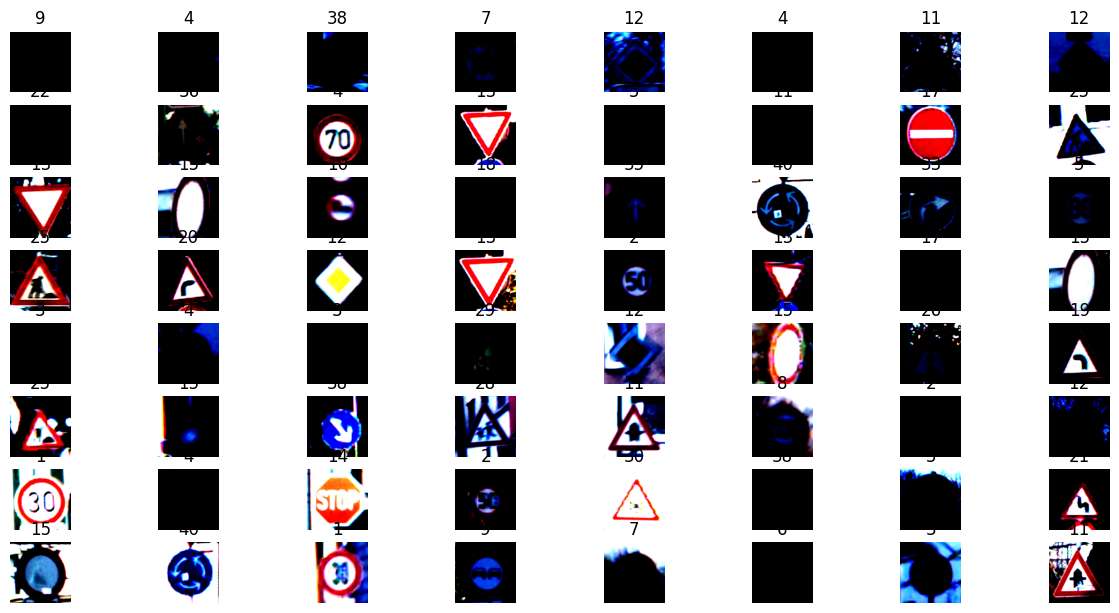

In [17]:
test_vis_data_loader = DataLoader(test_vis_set, batch_size=64, shuffle=False)

images, labels = next(iter(test_vis_data_loader)) # get a pack (64) of images
imshow(images, labels)

### **Setting up our model**



In [18]:
# Here we fix the hyperparameters that we will be using
bs = 64  # batch size
lr = 0.1  # learning rate
epochs = 20  # number of epochs
momentum = 0.9
step_size = 7
gamma = 0.1

Here we specify the structure of our model

In [19]:
model = torchvision.models.mobilenet_v2(pretrained=True)

in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
    nn.Linear(in_feature_number, 512),
    nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
    nn.ReLU(),
    nn.Linear(512, 43)
)

# We initialize the new added layers with the seed so we can reproduce the
# experiments.
for layer in model.classifier :
    if isinstance(layer, nn.Linear):  # Check if the layer is a Linear layer
        init.xavier_uniform_(layer.weight, gain=init.calculate_gain('relu'))  # Xavier initialization
        if layer.bias is not None:
            init.zeros_(layer.bias)  # Initialize biases to zeros


/home/pablo/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pablo/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/pablo/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100.0%


#### **Some useful functions:**


Visualizing the loss and accuracy for validation and training


In [20]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    plt.plot(train_acc)
    plt.title("Training accuracy")

    plt.subplot(2,2,2)
    plt.plot(val_acc)
    plt.title("Validation accuracy")

    plt.subplot(2,2,3)
    plt.plot(train_loss)
    plt.title("Training loss")

    plt.subplot(2,2,4)
    plt.plot(val_loss)
    plt.title("Validation loss")

    plt.show()

Setting up the visualizing method

In [21]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
# Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot loss
    ax1.plot(train_loss, label='Training Loss', color='blue', marker='o')
    ax1.plot(val_loss, label='Validation Loss', color='orange', marker='o')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    # Plot accuracy
    ax2.plot(train_acc, label='Training Accuracy', color='green', marker='o')
    ax2.plot(val_acc, label='Validation Accuracy', color='red', marker='o')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

Method to make predictions over a set of images

In [22]:
def evaluate_model(model, test_set, batch_size):
    was_training = model.training
    model.eval()

    model = model.to(device)

    all_preds = []
    all_labels = []

    test_data_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    return conf_matrix

Method to show some predictions on unseen images

In [23]:
def show_predictions(model, vis_set, batch_size, num_of_images=6):
    was_training = model.training
    model.eval()
    model = model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    vis_data_loader = DataLoader(vis_set, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(vis_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1, 2, 0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Method to show gradients

In [24]:
def plot_gradient_histogram(model):
    all_grads = []
    for param in model.classifier.parameters():
        if param.grad is not None:
            all_grads.append(param.grad.view(-1))
    if all_grads != []:
      all_grads = torch.cat(all_grads).cpu().numpy()

      plt.hist(all_grads, bins=100, range=(-1, 1))  # Adjust range if necessary
      plt.xlabel("Gradient Value")
      plt.ylabel("Frequency")
      plt.title("Gradient Histogram")
      plt.show()

#### **Training function**

Function for training our model

In [25]:
def train_model(model, criterion, optimizer, lr_scheduler, train_set, val_set, num_epochs=25, batch_size=64):
    #We keep track of the time it takes to run this function
    since = time.time()

    #We utilise the GPU if its avaliable
    model = model.to(device)

    # We initialise the value we want to keep after execution
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Lists that contain the values after each epoch
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    #We encapsulate our images and labels in a Dataloader

    train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    data_loader = { "train" : train_data_loader, "val" : val_data_loader }
    data_loader_len = { "train" : len(train_data_loader), "val" : len(val_data_loader) }
    print("DataLoaders set up succesfully")
    #We repeat this proccess for the number of epochs fixed
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                lr_scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

            epoch_loss = running_loss / data_loader_len[phase]
            epoch_acc = running_corrects.double() / data_loader_len[phase]

            if phase == 'train':
                train_acc.append(float(epoch_acc))
                train_loss.append(float(epoch_loss))
            else:
                val_acc.append(float(epoch_acc))
                val_loss.append(float(epoch_loss))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            plot_gradient_histogram(model)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    visualize_metrics(train_acc, val_acc, train_loss, val_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

### **Transfer learning**

We prepare our model for transer learning.

In [26]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion_loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizerSGD, step_size= step_size, gamma= gamma)

Let's aplicate transfer learning

DataLoaders set up succesfully
Epoch 1/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 49.1607 Acc: 49.4865


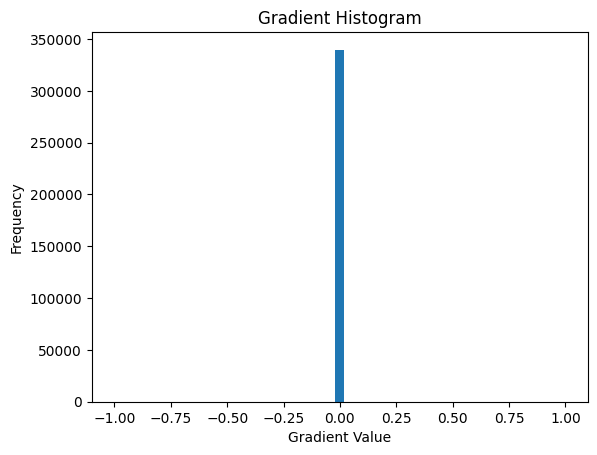

val Loss: 21.7347 Acc: 56.3929
Epoch 2/20
--------------------
train Loss: 13.1045 Acc: 59.6607


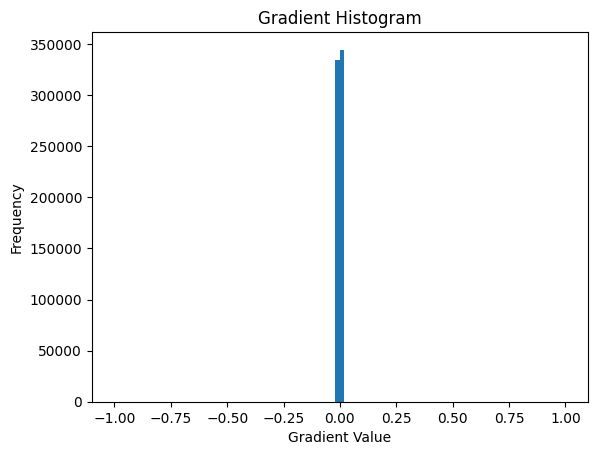

val Loss: 15.1724 Acc: 58.4405
Epoch 3/20
--------------------
train Loss: 7.4794 Acc: 61.6306


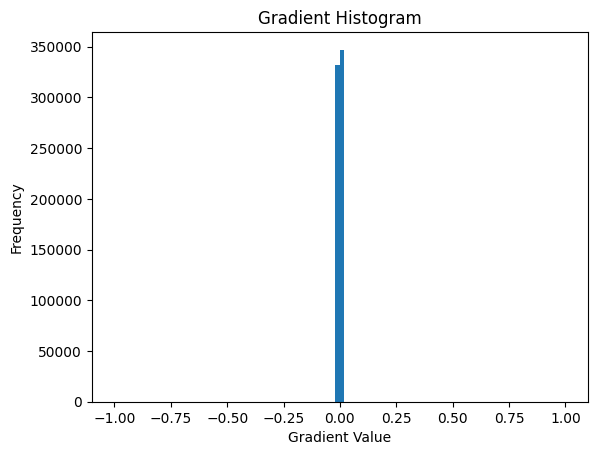

val Loss: 13.1571 Acc: 59.2024
Epoch 4/20
--------------------
train Loss: 4.9413 Acc: 62.4174


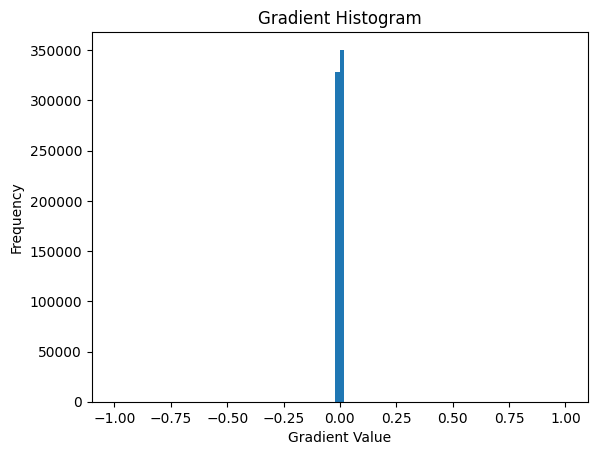

val Loss: 11.9643 Acc: 59.5952
Epoch 5/20
--------------------
train Loss: 3.0775 Acc: 63.0450


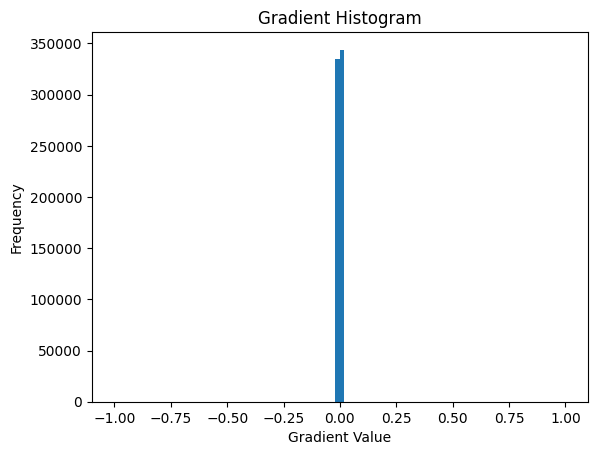

val Loss: 10.3501 Acc: 60.2738
Epoch 6/20
--------------------
train Loss: 2.4302 Acc: 63.2643


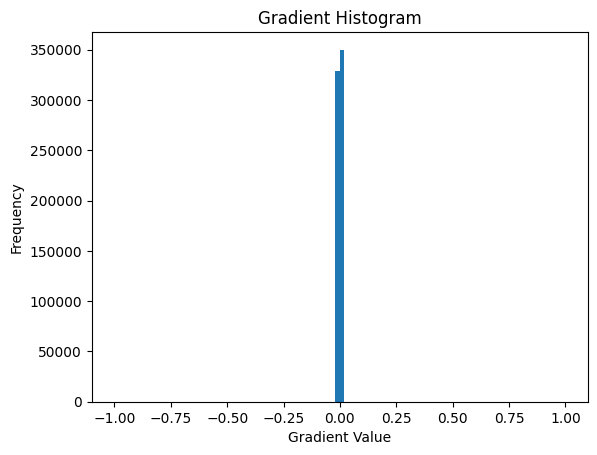

val Loss: 8.7076 Acc: 60.6071
Epoch 7/20
--------------------
train Loss: 1.2121 Acc: 63.7327


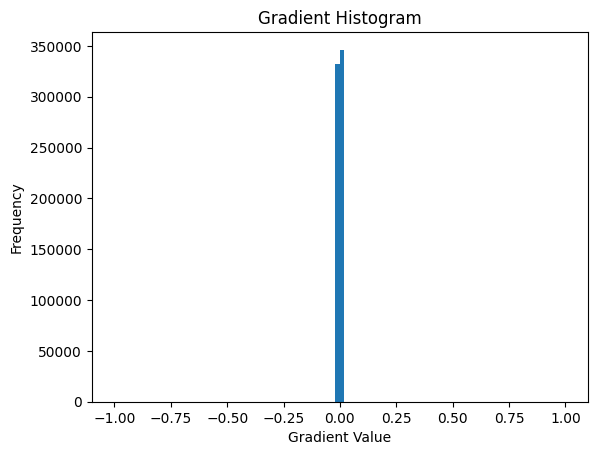

val Loss: 6.9731 Acc: 61.3214
Epoch 8/20
--------------------
train Loss: 0.8925 Acc: 63.8288


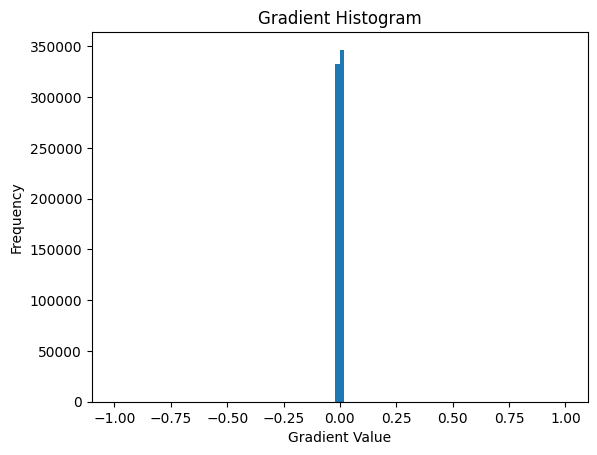

val Loss: 6.5686 Acc: 61.3214
Epoch 9/20
--------------------
train Loss: 0.7821 Acc: 63.8739


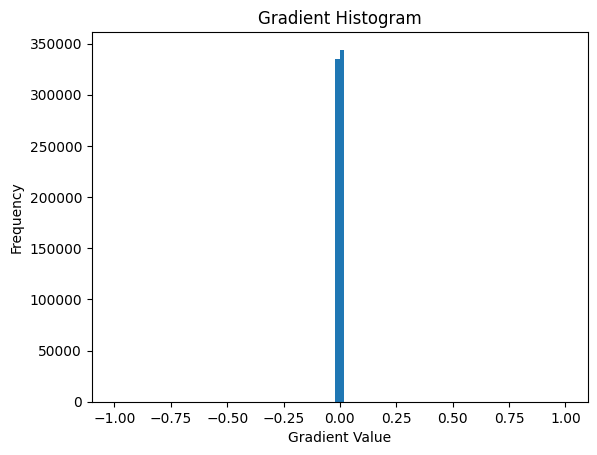

val Loss: 6.2391 Acc: 61.4643
Epoch 10/20
--------------------
train Loss: 0.7758 Acc: 63.8559


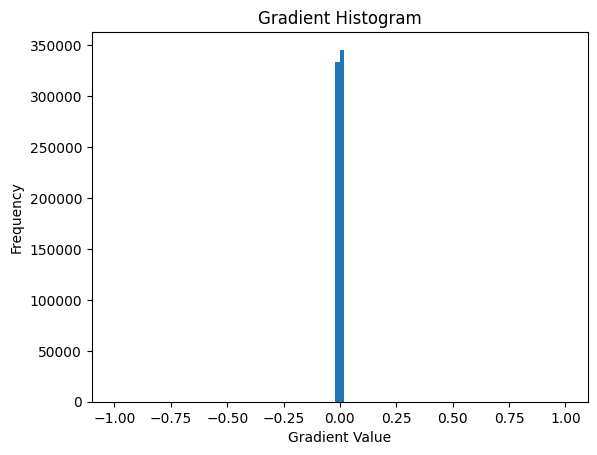

val Loss: 6.5381 Acc: 61.3929
Epoch 11/20
--------------------
train Loss: 0.6840 Acc: 63.8829


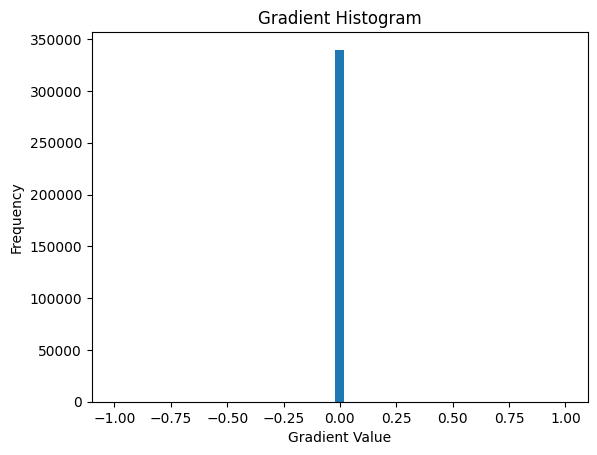

val Loss: 6.4061 Acc: 61.3810
Epoch 12/20
--------------------
train Loss: 0.5978 Acc: 63.9159


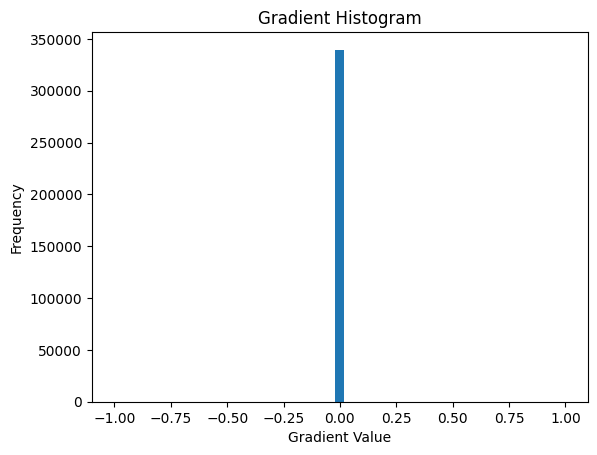

val Loss: 6.4659 Acc: 61.3214
Epoch 13/20
--------------------
train Loss: 0.5489 Acc: 63.9339


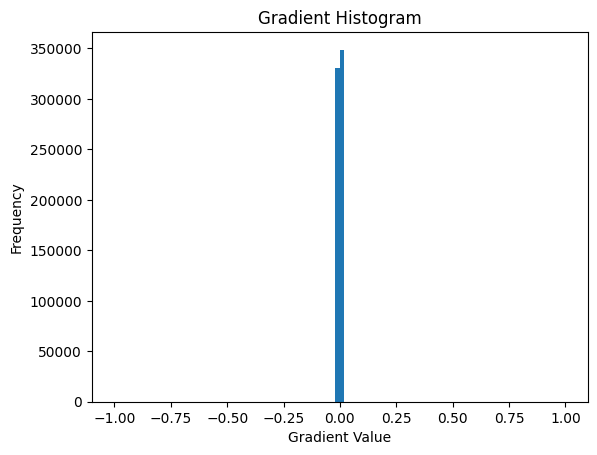

val Loss: 6.3742 Acc: 61.3333
Epoch 14/20
--------------------
train Loss: 0.5564 Acc: 63.9159


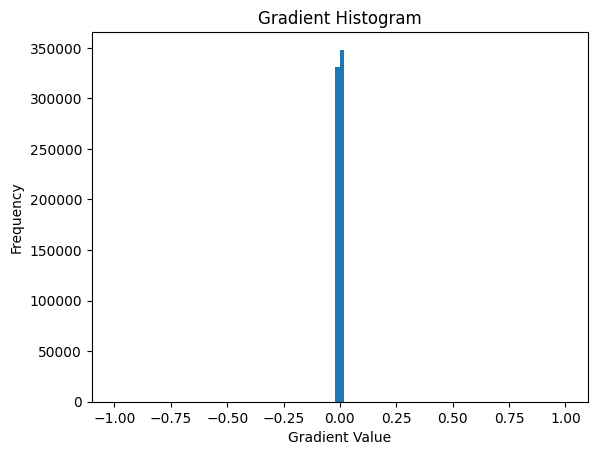

val Loss: 6.3939 Acc: 61.3333
Epoch 15/20
--------------------
train Loss: 0.5303 Acc: 63.9129


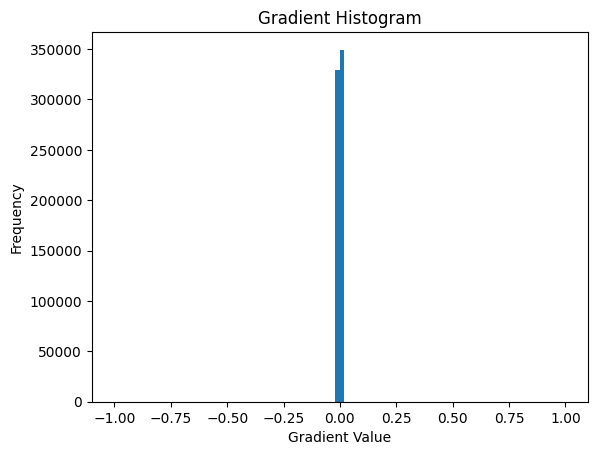

val Loss: 6.1303 Acc: 61.4762
Epoch 16/20
--------------------
train Loss: 0.5162 Acc: 63.9219


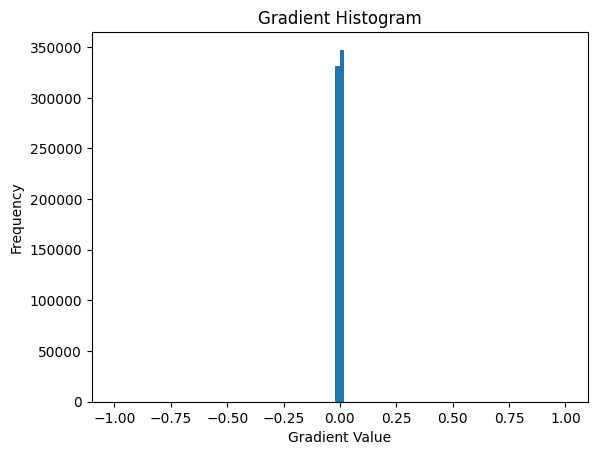

val Loss: 6.1921 Acc: 61.4762
Epoch 17/20
--------------------
train Loss: 0.5303 Acc: 63.8949


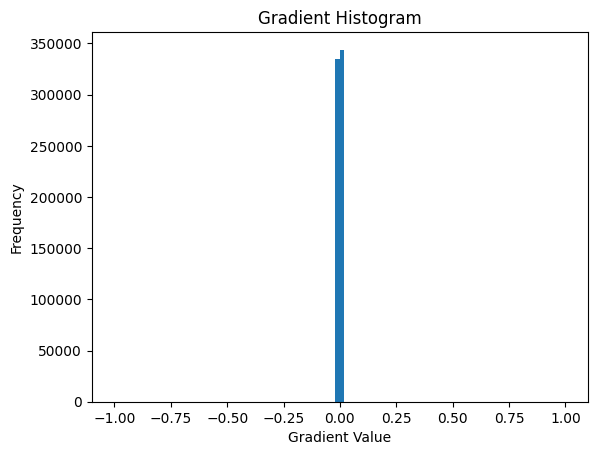

val Loss: 6.0835 Acc: 61.5357
Epoch 18/20
--------------------
train Loss: 0.5457 Acc: 63.9339


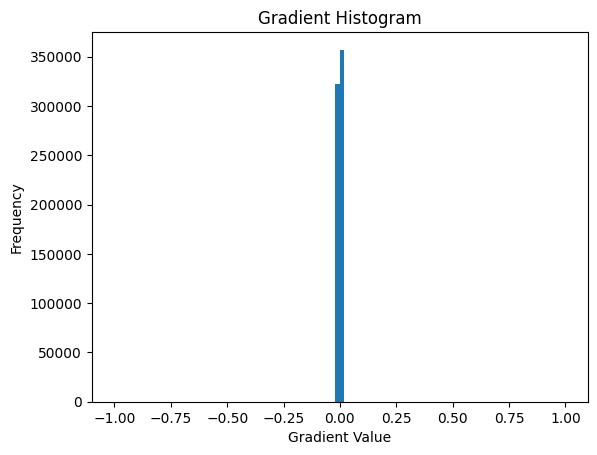

val Loss: 6.2701 Acc: 61.3571
Epoch 19/20
--------------------
train Loss: 0.5562 Acc: 63.9159


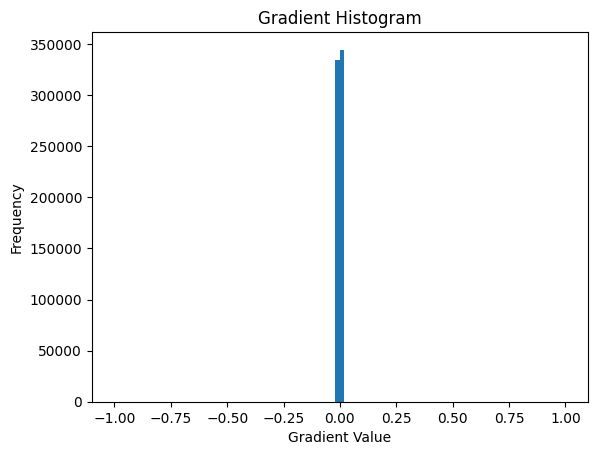

val Loss: 6.1185 Acc: 61.4048
Epoch 20/20
--------------------
train Loss: 0.4985 Acc: 63.9429


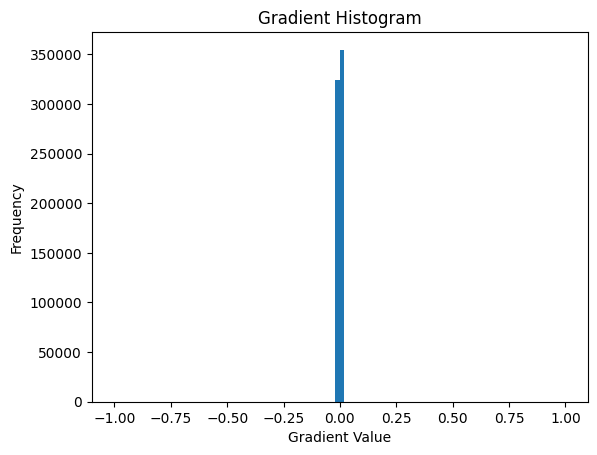

val Loss: 6.0825 Acc: 61.4643
Training complete in 41m 44s
Best val Acc: 61.535714


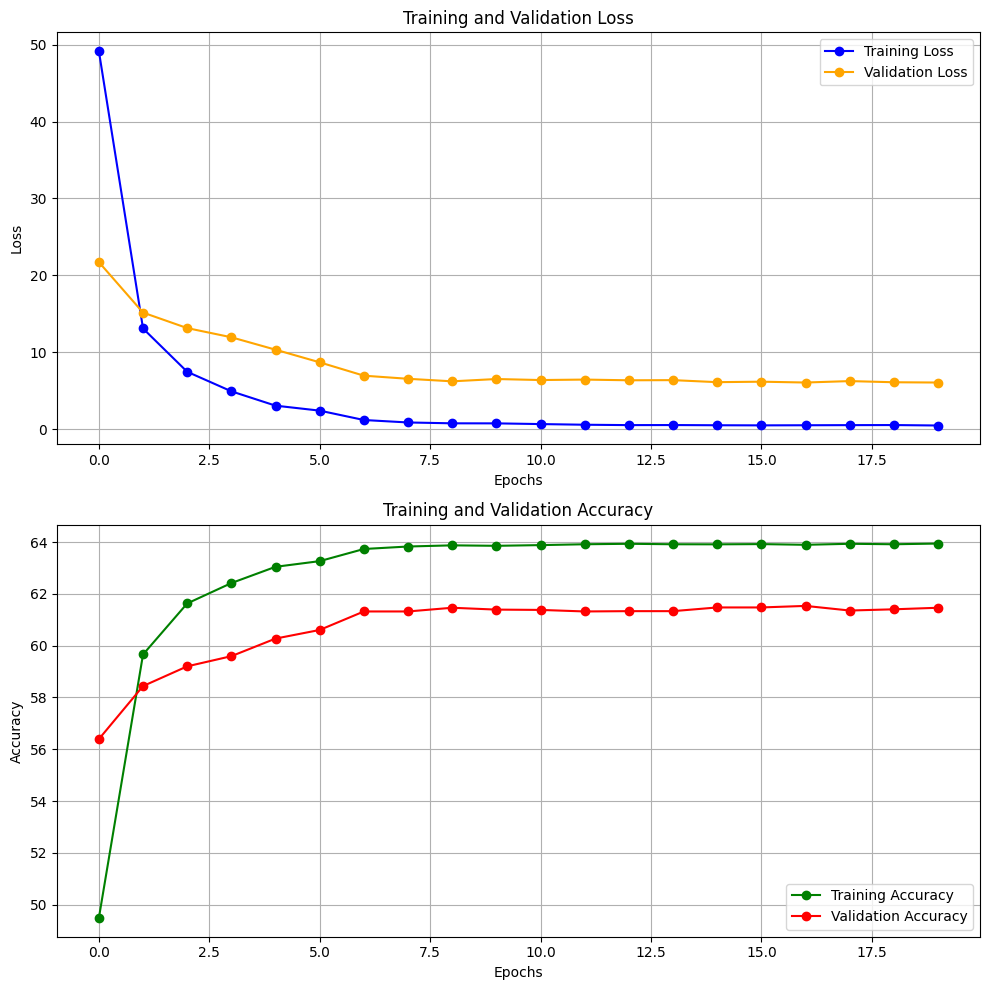

In [ ]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=epochs, batch_size=bs)

Let's visuzalize the results with a confusion matrix over the test set.

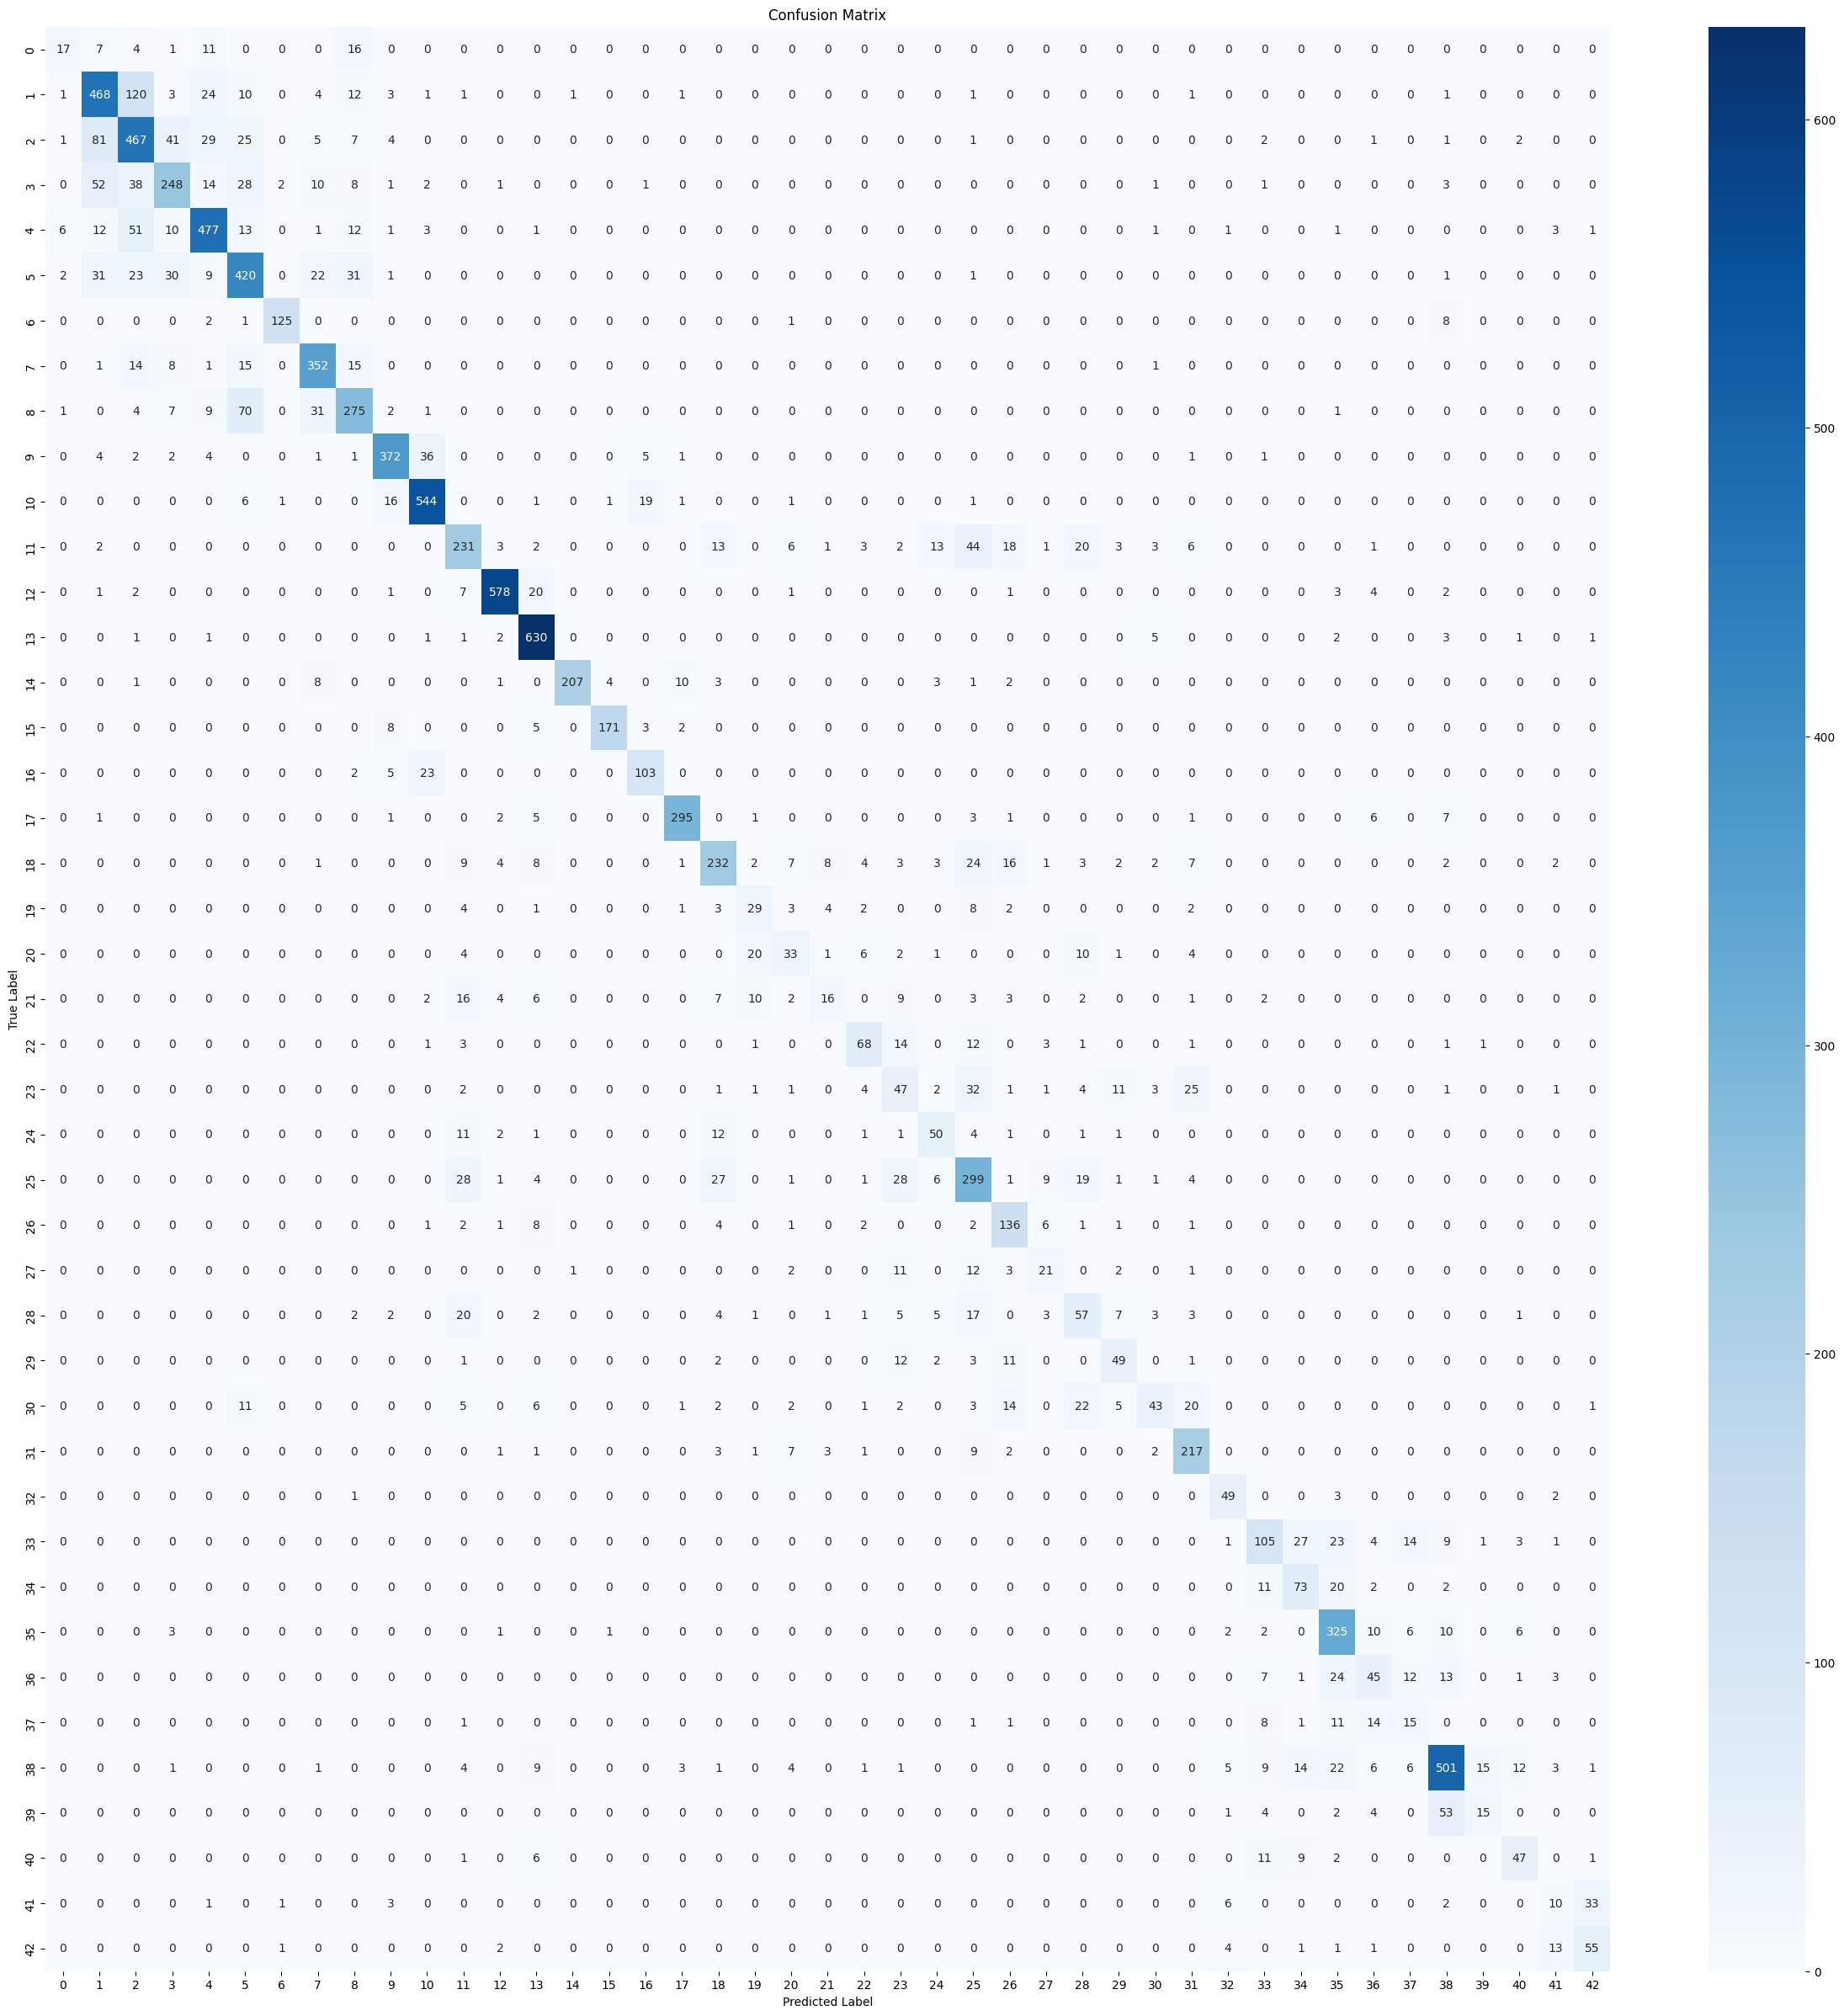

In [ ]:
conf_matrix = evaluate_model(model, test_set, bs)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Let's see a batch of the predictions and their true labels

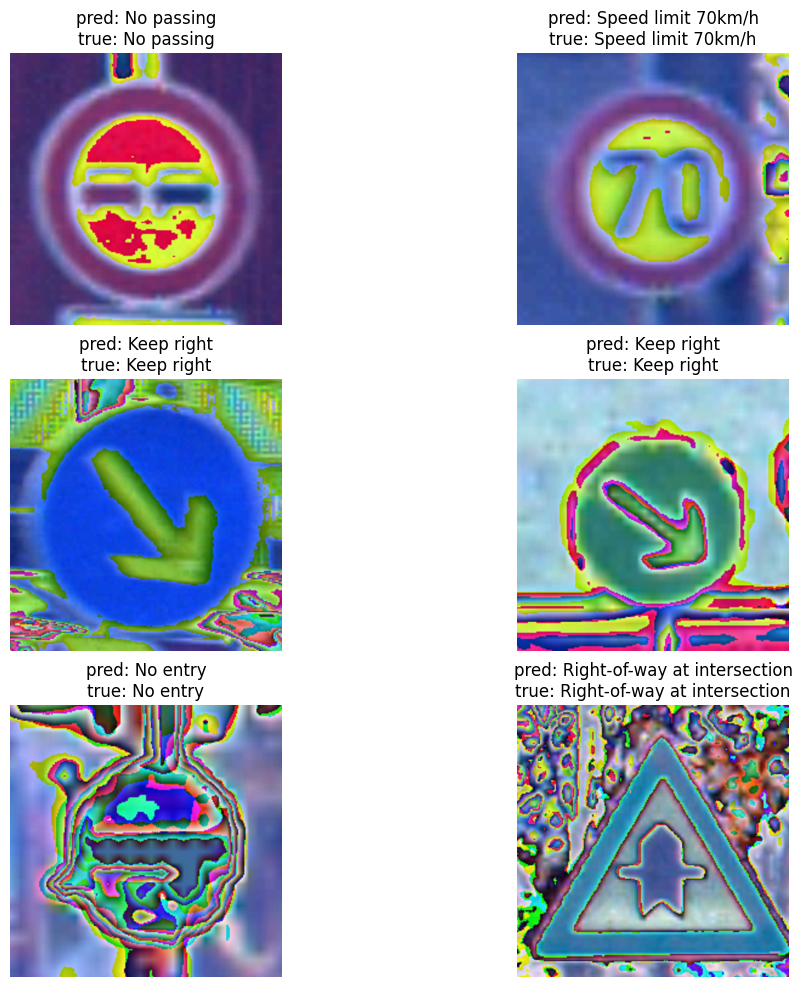

In [ ]:
show_predictions(model, test_vis_set, bs) # 6 images are shown by default

### **Fine tuning**

We unfreeze the decoder

In [ ]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Now we retrain the model for a few epochs

DataLoaders set up succesfully
Epoch 1/20
--------------------
train Loss: 0.5951 Acc: 63.8979


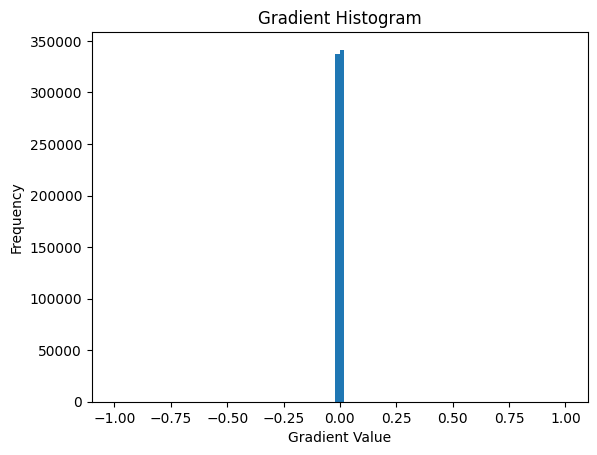

val Loss: 6.5396 Acc: 61.3929
Epoch 2/20
--------------------
train Loss: 0.4591 Acc: 63.9279


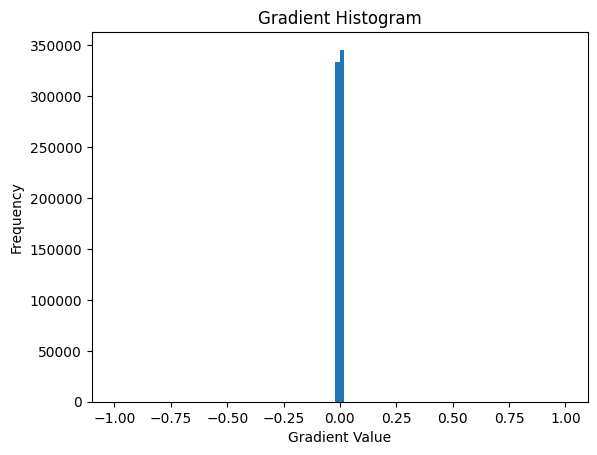

val Loss: 5.3875 Acc: 61.7976
Epoch 3/20
--------------------
train Loss: 0.3744 Acc: 63.9489


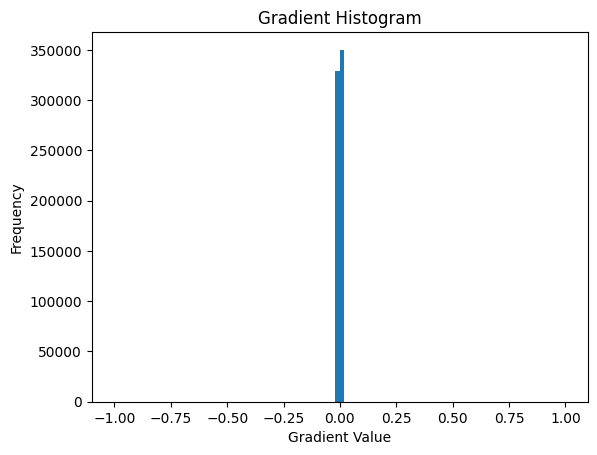

val Loss: 4.6823 Acc: 61.9643
Epoch 4/20
--------------------
train Loss: 0.2871 Acc: 63.9670


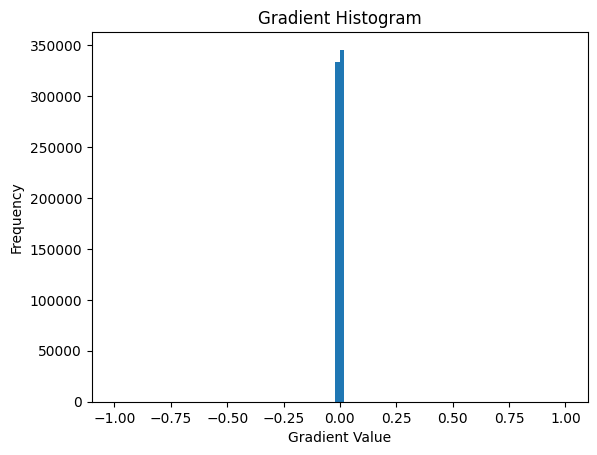

val Loss: 4.8405 Acc: 61.8929
Epoch 5/20
--------------------
train Loss: 0.3141 Acc: 63.9700


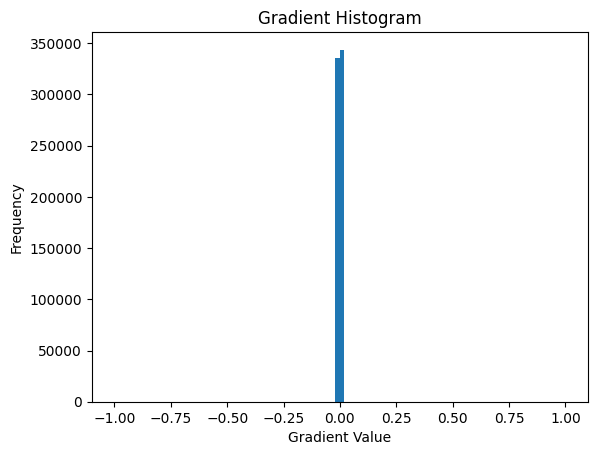

val Loss: 5.0397 Acc: 61.7143
Epoch 6/20
--------------------
train Loss: 0.2606 Acc: 63.9760


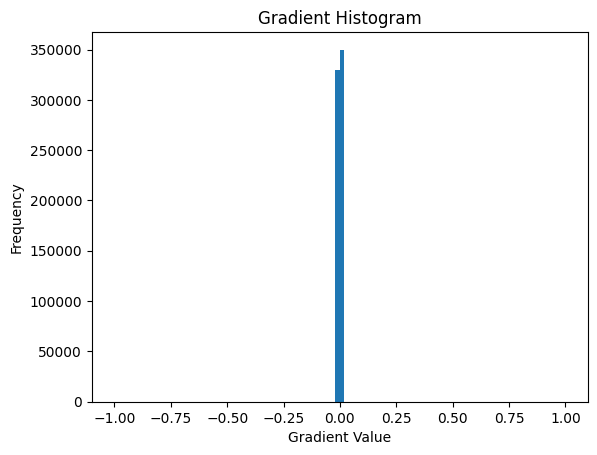

val Loss: 4.1740 Acc: 62.0119
Epoch 7/20
--------------------
train Loss: 0.2063 Acc: 63.9910


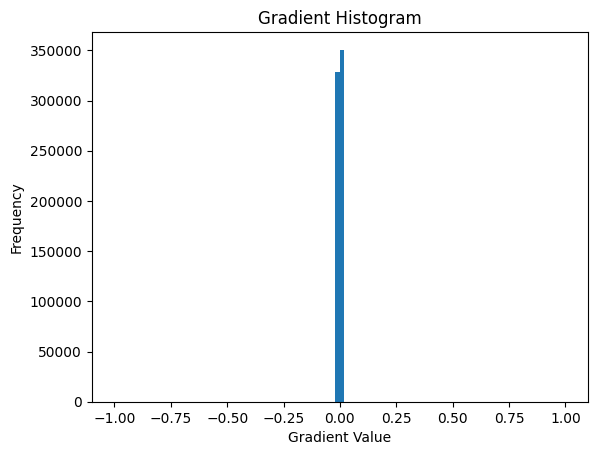

val Loss: 3.9987 Acc: 62.1667
Epoch 8/20
--------------------
train Loss: 0.2039 Acc: 63.9790


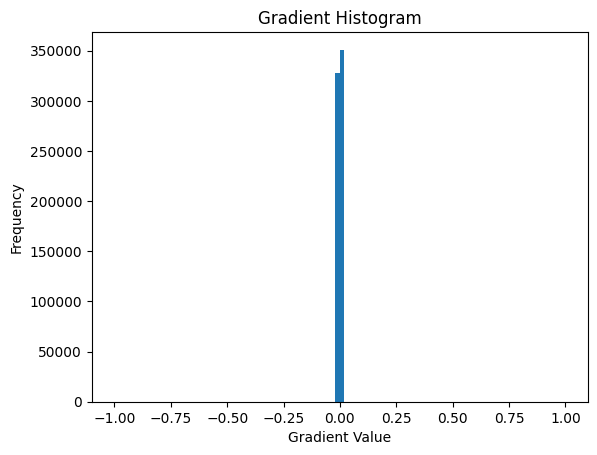

val Loss: 3.9854 Acc: 62.1429
Epoch 9/20
--------------------
train Loss: 0.1976 Acc: 63.9790


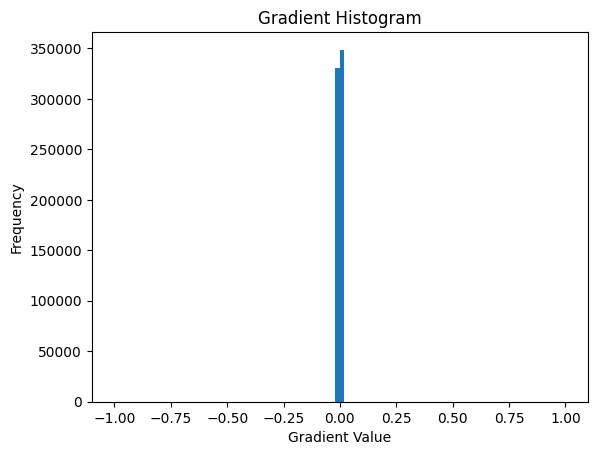

val Loss: 3.9257 Acc: 62.2024
Epoch 10/20
--------------------
train Loss: 0.1779 Acc: 63.9880


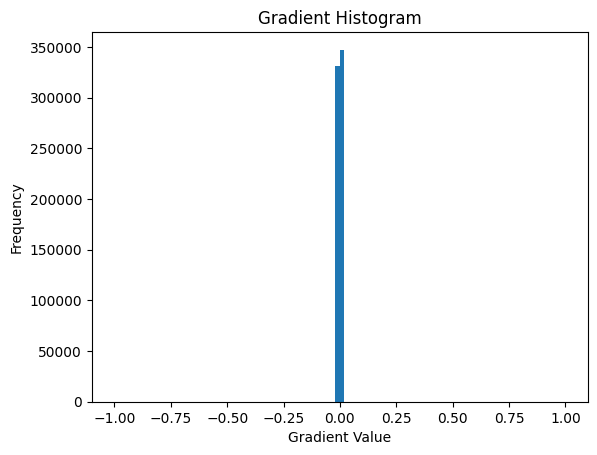

val Loss: 4.0272 Acc: 62.2024
Epoch 11/20
--------------------
train Loss: 0.2110 Acc: 63.9790


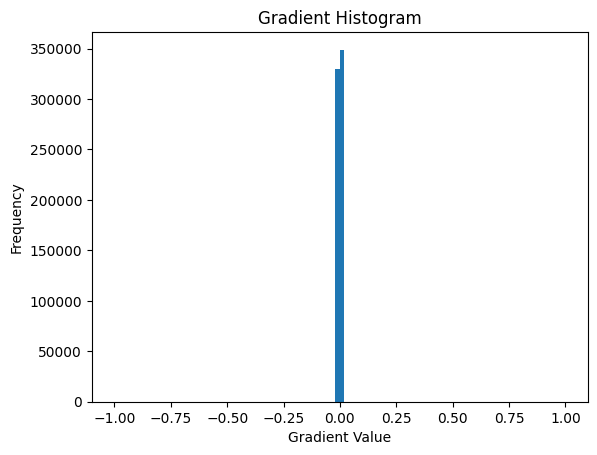

val Loss: 3.9026 Acc: 62.2262
Epoch 12/20
--------------------
train Loss: 0.1810 Acc: 63.9880


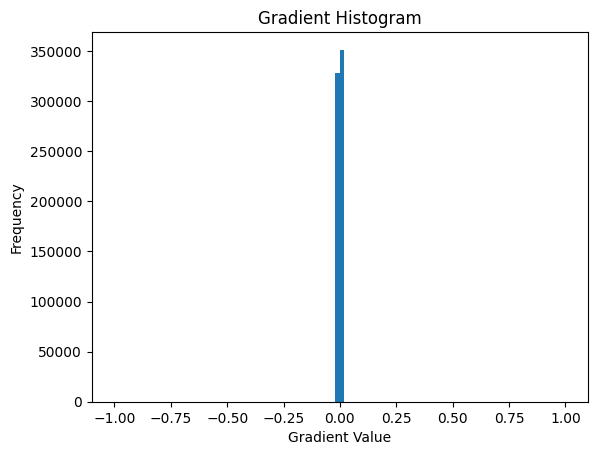

val Loss: 3.8935 Acc: 62.2024
Epoch 13/20
--------------------
train Loss: 0.1847 Acc: 63.9910


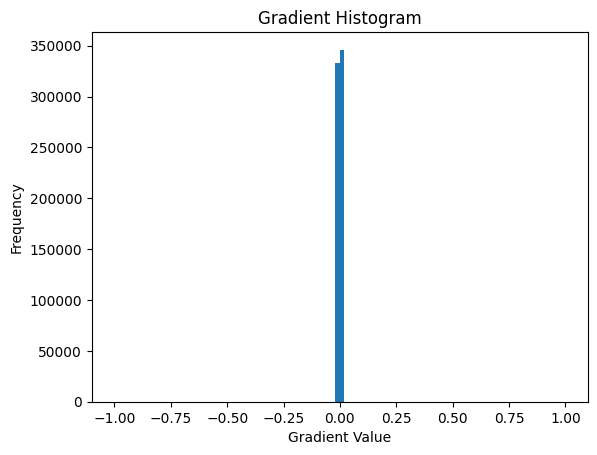

val Loss: 3.8072 Acc: 62.1786
Epoch 14/20
--------------------


KeyboardInterrupt: 

In [ ]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=epochs)

And finally we visualize the results:


In [ ]:
conf_matrix = evaluate_model(model, test_vis_set, bs)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### **Experimenting with increasing the learning rate**

The motivation for experimenting with the learning rate comes from the fact that, because our gradients were vanishing, we decided to add a Batch Normalization layer. Therefore now we can try to initialize our model with higher learning rates. We also want to achieve a better accuracy, therefore we
will try to use CLR and a deeper study of the reasonable boundaries that
are suitable for our model and dataset.

In [27]:
#First of all let's get our model back to the early stage

def reset_parameters(model) :
  model = torchvision.models.mobilenet_v2(pretrained=True)

  in_feature_number = model.classifier[1].in_features

  model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
      nn.Linear(in_feature_number, 512),
      nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
      nn.ReLU(),
      nn.Linear(512, 43)
  )

  # We initialize the new added layers with the seed so we can reproduce the
  # experiments.
  for layer in model.classifier :
      if isinstance(layer, nn.Linear):  # Check if the layer is a Linear layer
          init.xavier_uniform_(layer.weight, gain=init.calculate_gain('relu'))  # Xavier initialization
          if layer.bias is not None:
              init.zeros_(layer.bias)  # Initialize biases to zeros

  return model


Let's also modify our train function so we can play with the learning rates more easily and efficientrly

In [41]:
def train_model(model,
                criterion,
                optimizer,
                lr_scheduler,
                train_set,
                val_set,
                num_epochs=25,
                batch_size=2,
                batches_per_epoch=None,
                show = False
                ):
    #We keep track of the time it takes to run this function
    since = time.time()

    #We utilise the GPU if its avaliable
    model = model.to(device)

    # We initialise the value we want to keep after execution
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Lists that contain the values after each epoch
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    train_acc_hist = []
    val_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []

    plot_time_train = []
    plot_time_valid = []

    #We encapsulate our images and labels in a Dataloader

    # Set up data loaders
    if batches_per_epoch == None:
      # Use all images
      train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=bs,
                                            shuffle=True, num_workers=2)
      val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=bs,
                                          shuffle=False, num_workers=2)
      batches_per_epoch = len(train_data_loader)
    else:
      # Only use a subset of the data
      subset_indices = list(range(batches_per_epoch*bs))
      train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices, ), num_workers=2)

      # Use one fourth for validation
      subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
      val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)


    data_loader = { "train" : train_data_loader, "val" : val_data_loader }
    data_loader_len = { "train" : len(train_data_loader), "val" : len(val_data_loader) }
    print("DataLoaders set up succesfully")

    # Total number of batches
    t=1
    T = batches_per_epoch * epochs

    #We repeat this proccess for the number of epochs fixed
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} Batches per epoch: {batches_per_epoch} Total number of batches: {T}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                t = 1
            else:
                model.eval()   # Set model to evaluate mode
                t = 1

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                optimizer.param_groups[0]['lr'] = lr_scheduler(t,T,lr=optimizer.param_groups[0]['lr'])

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

                if phase == 'train':
                  train_acc_hist.append(float(curr_corrects))
                  train_loss_hist.append(float(curr_loss))
                  print('t',t,'lr',optimizer.param_groups[0]['lr'],'train loss',curr_loss)
                  plot_time_train.append(t)
                  t += 1
                else:
                  val_acc_hist.append(float(curr_corrects))
                  val_loss_hist.append(float(curr_loss))
                  plot_time_valid.append(t)
                  t += 1

            epoch_loss = running_loss / data_loader_len[phase]
            epoch_acc = running_corrects.double() / data_loader_len[phase]

            if phase == 'train':
                train_acc.append(float(curr_corrects))
                train_loss.append(float(curr_loss))
            else:
                val_acc.append(float(curr_corrects))
                val_loss.append(float(curr_loss))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if show == True :
              plot_gradient_histogram(model)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
    #    time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))
#
    #visualize_metrics(train_acc, val_acc, train_loss, val_loss)
#
    ## load best model weights
    model.load_state_dict(best_model_wts)

    if show == True :
      plt.figure()
      lines = []
      labels = []
      l, = plt.plot(plot_time_train,train_loss_history)
      lines.append(l)
      labels.append('Training')
      plt.title('Loss')
      plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
      plt.show()
    #We return the train_loss
    return train_loss_hist

In [42]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

In [43]:
#Let's experiment with different learning rates and see which ones are more
# interesting for our model.

epochs = 1
batches_per_epoch = 50
lr_list = np.logspace(-6,0,batches_per_epoch) # Your code goes here
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

print(lr_list)

# Run
model = reset_parameters(model)

train_loss_history = train_model(model, criterion_loss, optimizerSGD, lr_finder, train_set, val_set, num_epochs=epochs,batches_per_epoch=batches_per_epoch)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis
plt.xlabel('Learning rate');
plt.ylabel('Loss');

[1.00000000e-06 1.32571137e-06 1.75751062e-06 2.32995181e-06
 3.08884360e-06 4.09491506e-06 5.42867544e-06 7.19685673e-06
 9.54095476e-06 1.26485522e-05 1.67683294e-05 2.22299648e-05
 2.94705170e-05 3.90693994e-05 5.17947468e-05 6.86648845e-05
 9.10298178e-05 1.20679264e-04 1.59985872e-04 2.12095089e-04
 2.81176870e-04 3.72759372e-04 4.94171336e-04 6.55128557e-04
 8.68511374e-04 1.15139540e-03 1.52641797e-03 2.02358965e-03
 2.68269580e-03 3.55648031e-03 4.71486636e-03 6.25055193e-03
 8.28642773e-03 1.09854114e-02 1.45634848e-02 1.93069773e-02
 2.55954792e-02 3.39322177e-02 4.49843267e-02 5.96362332e-02
 7.90604321e-02 1.04811313e-01 1.38949549e-01 1.84206997e-01
 2.44205309e-01 3.23745754e-01 4.29193426e-01 5.68986603e-01
 7.54312006e-01 1.00000000e+00]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 1.95 GiB of which 1.62 MiB is free. Including non-PyTorch memory, this process has 1.94 GiB memory in use. Of the allocated memory 1.88 GiB is allocated by PyTorch, and 17.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Seeing the above graph makes us think that the best learning rates will be from 10^{-3/2} to 10^{-1}. Therefore we apply CLR with those values.

In [ ]:
lr_list = np.logspace(-3,-1,50) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
print(lr_list)
batches_per_epoch = len(lr_list)
epochs = 1
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


def CLR(t,T,lr):
  return lr_list[t-1]

model = reset_parameters(model)
for cycle in range(5):
  train_loss_history = train_model(model, criterion_loss, optimizerSGD, CLR, train_set, val_set, num_epochs=epochs,batches_per_epoch=batches_per_epoch, show=True)


[0.1        0.09102982 0.08286428 0.0754312  0.06866488 0.06250552
 0.05689866 0.05179475 0.04714866 0.04291934 0.0390694  0.0355648
 0.03237458 0.02947052 0.02682696 0.02442053 0.02222996 0.0202359
 0.0184207  0.01676833 0.01526418 0.01389495 0.01264855 0.01151395
 0.01048113 0.00954095 0.00868511 0.00790604 0.00719686 0.00655129
 0.00596362 0.00542868 0.00494171 0.00449843 0.00409492 0.00372759
 0.00339322 0.00308884 0.00281177 0.00255955 0.00232995 0.00212095
 0.0019307  0.00175751 0.00159986 0.00145635 0.00132571 0.00120679
 0.00109854 0.001     ]
DataLoaders set up succesfully
Epoch 1/1 Batches per epoch: 50 Total number of batches: 50
--------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


t 1 lr 0.1 train loss 272.90325927734375


### **Experimenting with the optimizers**

Since our gradients seem to still vanish, and our accuracy is still pretty low after fine tuning, seems like choosing the appropiate learning rate is not working the way we have been doing it so far. Therefore we will try to use another optimizer, concretely the Adam optimizer,

In [ ]:
optimi_adam = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


DataLoaders set up succesfully
Epoch 1/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 90.6452 Acc: 40.2012


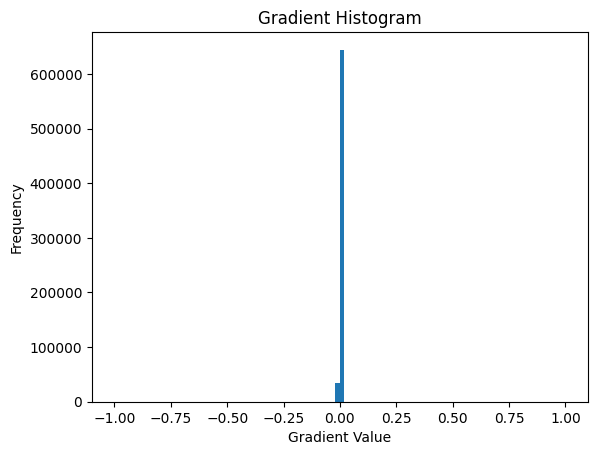

val Loss: 51.0906 Acc: 46.1310
Epoch 2/20
--------------------
train Loss: 46.6070 Acc: 49.3213


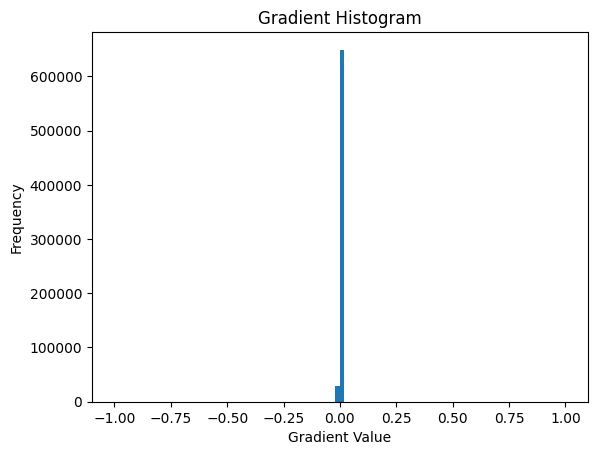

In [ ]:
model = train_model(model, criterion_loss, optimi_adam, exp_lr_scheduler, train_set, val_set, num_epochs=epochs, batch_size=bs)